#**Frappy - A FRED Library**

##0.Moduli

###0.1.model.py

In [ ]:
from enum import Enum


class Category:
    def __init__(self, cat_id, name, parent_id, leaf, n_children, n_series):
        self.cat_id = cat_id
        self.name = name
        self.parent_id = parent_id
        self.leaf = leaf
        self.n_children = n_children
        self.n_series = n_series
        self.children = []
        self.series_list = []

    def __str__(self):
        return "ID: " + str(self.cat_id) + " NAME: " + self.name + " parentID: " + str(self.parent_id) + " leaf: " + str(self.leaf) + " n_series: " + str(self.n_series)


class Series:
    def __init__(self, series_id, title, category_id, n_observables):
        self.series_id = series_id
        self.title = title
        self.category_id = category_id
        self.n_observables = n_observables
        self.observables = []

    def __str__(self):
        return "ID: " + str(self.series_id) + " TITLE: " + str(self.title) + " categoryID: " + str(self.category_id)


class Observable:
    def __init__(self, observable_id, date, value, series_id):
        self.observable_id = observable_id
        self.date = date
        self.value = value
        self.series = series_id

    def __str__(self):
        return "DATE: " + self.date + " VALUE: " + str(self.value) + " seriesID: " + str(self.series)


class ClassType(Enum):
    """
    enum that represents the model types\n
    """
    CATEGORY = 1
    SERIES = 2
    OBSERVABLE = 3
    CHILD = 4


def object_convert(model_type: ClassType, dict_state: dict):
    """
    converts format from dictionary to model object\n
    :param model_type: type of the model class\n
    :param dict_state: dictionary of the object state\n
    :return: object from model\n
    """
    obj = None
    if model_type is ClassType.CATEGORY:
        obj = Category(dict_state['id'], dict_state['name'], dict_state['parent_id'], dict_state['is_leaf'], dict_state['n_children'], dict_state['n_series'])
    elif model_type is ClassType.SERIES:
        obj = Series(dict_state['id'], dict_state['title'], dict_state['category_id'], dict_state['n_observables'])
    elif model_type is ClassType.OBSERVABLE:
        obj = Observable(dict_state['id'], dict_state['date'], dict_state['value'], dict_state['series_id'])
    return obj

###0.2.core.py

In [ ]:
import sqlite3
from sqlite3 import Error


"""
This module is private and contains the definitions of classes and exceptions
used in this package to interact with the FRED API.
"""
__database_conf = {'tables': ['Category', 'Series', 'Observable'],
                   'attributes': {'Category': [('id', 'INTEGER PRIMARY KEY'),
                                               ('name', 'TEXT NOT NULL'),
                                               ('parent_id', 'INTEGER REFERENCES Category(id) '
                                                             'ON DELETE CASCADE ON UPDATE CASCADE'),
                                               ('is_leaf', 'INTEGER'),
                                               ('n_children', 'INTEGER'),
                                               ('n_series', 'INTEGER')],
                                  'Series': [('id', 'TEXT PRIMARY KEY'),
                                             ('title', 'TEXT NOT NULL'),
                                             ('category_id', 'INTEGER REFERENCES Category(id) '
                                                             'ON DELETE CASCADE ON UPDATE CASCADE'),
                                             ('n_observables', 'INTEGER')],
                                  'Observable': [('id', 'INTEGER PRIMARY KEY AUTOINCREMENT'),
                                                 ('date', 'TEXT NOT NULL'),
                                                 ('value', 'INTEGER'),
                                                 ('series_id', 'INTEGER REFERENCES Series(id) '
                                                               'ON DELETE CASCADE ON UPDATE CASCADE')]}
                   }


def _read_creation_conf() -> str:
    """
    Reads the database configuration entries to build a database query\n
    :return: a database query
    """
    tables = __database_conf['tables']
    creation_query = ""
    for i in range(len(tables)):
        first_time = True
        query = "CREATE TABLE IF NOT EXISTS "
        attrs = __database_conf['attributes'][tables[i]]
        query += tables[i] + "("
        for a in attrs:
            if not first_time:
                query += ","
            query += a[0] + " " + a[1]
            first_time = False
        query += ");"
        creation_query += query
        creation_query += " "
    return creation_query


class DatabaseManager:
    """
    This is a class to interact with the database of the package\n
    """

    def __init__(self, db_name: str):
        self.conn = None
        if self.conn is None:
            if db_name.endswith(".db"):
                self.db_name = db_name
            else:
                self.db_name = db_name + ".db"
            self.conn = sqlite3.connect(self.db_name)
            self.conn.execute('pragma journal_mode=wal')
            # create tables in the database configuration
            cur = self.conn.cursor()
            queries = _read_creation_conf().split(";")
            for q in queries:
                cur.execute(q)
                self.conn.commit()

    def commit(self):
        """
        force connection commit
        :return: None\n
        """
        self.conn.commit()

    def insert_category(self, category: Category):
        """
        insert a new Category in the database\n
        :param category: the category to insert\n
        :return: None\n
        """
        insert_category_query = "REPLACE INTO Category (id, name, parent_id, is_leaf, n_children, n_series) VALUES(?,?,?,?,?,?)"
        values = [category.cat_id, category.name]
        # TODO probabilemte si può levare il controllo sul parent id
        if category.parent_id is not None:
            values.append(category.parent_id)
        else:
            values.append(None)
        values.append(category.leaf)
        values.append(category.n_children)
        values.append(category.n_series)
        try:
            cur = self.conn.cursor()
            cur.execute(insert_category_query, values)
            self.conn.commit()
        except Error as e:
            print(e)

    def insert_series(self, series: Series, commit_flag):
        """
        insert a new Series object in the database\n
        :param commit_flag: flag used to force commit to db\n
        :param series: the series to insert\n
        :return: None\n
        """
        insert_series_query = "REPLACE INTO Series (id, title, category_id, n_observables) VALUES(?,?,?,?)"
        values = [series.series_id, series.title, series.category_id, series.n_observables]
        try:
            cur = self.conn.cursor()
            cur.execute(insert_series_query, values)
            if commit_flag == 1:
                self.conn.commit()
        except Error as e:
            print(e)

    def insert_observable(self, observable: Observable, commit_flag):
        """
        insert a new Observable object in the database\n
        :param observable: the observable to insert\n
        :return: None\n
        """
        insert_observable_query = "REPLACE INTO Observable(date, value, series_id) VALUES(?,?,?)"
        values = [observable.date, observable.value, observable.series]
        try:
            cur = self.conn.cursor()
            cur.execute(insert_observable_query, values)
            if commit_flag == 1:
                self.conn.commit()
        except Error as e:
            print(e)

    def get_category(self, category_id) -> Category:
        """
        retrieve a category with given id from the database\n
        :param category_id: the id of the category to fetch\n
        :return: Category object\n
        """
        get_category_query = "SELECT * FROM Category WHERE id=?"
        sub = []
        try:
            cur = self.conn.cursor()
            cur.execute(get_category_query, [category_id])
            columns = [col[0] for col in cur.description]
            sub = [dict(zip(columns, row)) for row in cur.fetchall()]
        except Error as e:
            print(e)
        return sub

    def get_series(self, series_id) -> Series:
        """
        retrieve a series with given id from the database\n
        :param series_id: the id of the series to fetch\n
        :return: Series object\n
        """
        get_series_query = "SELECT * FROM Series WHERE id=?"
        try:
            cur = self.conn.cursor()
            cur.execute(get_series_query, [series_id])
            columns = [col[0] for col in cur.description]
            sub = [dict(zip(columns, row)) for row in cur.fetchall()]
        except Error as e:
            print(e)
        return sub

    def get_subcategories(self, category_id) -> [Category]:
        """
        get a list of children for the given category\n
        :param category_id: the id of the category whose children are to be retrieved\n
        :return: list of Category type children\n
        """
        get_subcategory_query = "SELECT * FROM Category WHERE parent_id=?"
        sub = []
        try:
            cur = self.conn.cursor()
            cur.execute(get_subcategory_query, [category_id])
            columns = [col[0] for col in cur.description]
            sub = [dict(zip(columns, row)) for row in cur.fetchall()]
        except Error as e:
            print(e)
        return sub

    def get_category_list(self) -> [Category]:
        """
        get a list of categories\n
        :return: list of Category\n
        """
        get_category_list_query = "SELECT * FROM Category"
        category_list = []
        try:
            cur = self.conn.cursor()
            cur.execute(get_category_list_query)
            columns = [col[0] for col in cur.description]
            category_list = [dict(zip(columns, row)) for row in cur.fetchall()]
        except Error as e:
            print(e)
        return category_list

    def get_series_list(self, category_id) -> [Series]:
        """
        get a list of series of a given category\n
        :param category_id: the given category\n
        :return: list of Series\n
        """
        get_series_list_query = "SELECT * FROM Series WHERE category_id=?"
        series_list = []
        try:
            cur = self.conn.cursor()
            cur.execute(get_series_list_query, [category_id])
            columns = [col[0] for col in cur.description]
            series_list = [dict(zip(columns, row)) for row in cur.fetchall()]
        except Error as e:
            print(e)
        return series_list

    def get_series_number(self, category_id):
        """
        get number of series of a given category\n
        :param category_id: the given category\n
        :return: number of Series integer\n
        """
        get_series_number_query = "SELECT n_series FROM Category WHERE id=?"
        series_number = -1
        try:
            cur = self.conn.cursor()
            cur.execute(get_series_number_query, [category_id])
            series_number = cur.fetchone()[0]
        except Error as e:
            print(e)
        return series_number

    def get_children_number(self, category_id):
        """
        get the number of children of a given category\n
        :param category_id:\n
        :return: children number\n
        """
        get_children_number_query = "SELECT n_children FROM Category WHERE id=?"
        children_number = -1
        try:
            cur = self.conn.cursor()
            cur.execute(get_children_number_query, [category_id])
            children_number = cur.fetchone()[0]
        except Error as e:
            print(e)
        return children_number

    def get_observable_list(self, series_id) -> [Observable]:
        """
        get a list of observables of a given series\n
        :param series_id: the given series\n
        :return: list of Observable\n
        """
        get_observables_query = "SELECT *  FROM Observable WHERE series_id=?"
        observables = []
        try:
            cur = self.conn.cursor()
            cur.execute(get_observables_query, [series_id])
            columns = [col[0] for col in cur.description]
            observables = [dict(zip(columns, row)) for row in cur.fetchall()]
        except Error as e:
            print(e)
        return observables

    def get_observables_number(self, category_id):
        """
        get number of series of a given category\n
        :param category_id: the given category\n
        :return: number of Series integer\n
        """
        get_observables_number_query = "SELECT n_observables FROM Series WHERE id=?"
        observables_number = -1
        try:
            cur = self.conn.cursor()
            cur.execute(get_observables_number_query, [category_id])
            observables_number = cur.fetchone()[0]
        except Error as e:
            print(e)
        return observables_number

    def get_series(self, series_id) -> Series:
        """
        get the series with the specified id in the database\n
        :param series_id: series id\n
        :return: a Series object\n
        """
        get_series_query = "SELECT * FROM Series WHERE series_id=?"
        series = []
        try:
            cur = self.conn.cursor()
            cur.execute(get_series_query, [series_id])
            columns = [col[0] for col in cur.description]
            series = [dict(zip(columns, row)) for row in cur.fetchall()]
        except Error as e:
            print(e)
        return series

    def update_category(self, category: Category):
        """
        update the category specified in the database\n
        :param category: the new state of the Category\n
        :return: None\n
        """
        update_category_query = "UPDATE Category SET name=?, parent_id=?, is_leaf=?, n_children=?, n_series=? where id=?"
        values = [category.name, category.parent_id, category.leaf, category.n_children, category.n_series, category.cat_id]
        try:
            c = self.conn.cursor()
            c.execute(update_category_query, values)
            self.conn.commit()
        except Error as e:
            print(e)

    def update_series(self, series: Series):
        """
        update the series specified in the database\n
        :param series: the new state of the Series\n
        :return: None\n
        """
        update_series_query = "UPDATE Series SET title=?, category_id=?, n_observables=? where id=?"
        values = [series.title, series.category_id, series.n_observables, series.series_id]
        try:
            cur = self.conn.cursor()
            cur.execute(update_series_query, values)
            self.conn.commit()
        except Error as e:
            print(e)

    def update_observable(self, observable: Observable):
        """
        update the observable specified in the database\n
        :param observable: the new state of the Observable\n
        :return: None\n
        """
        update_observable_query = "UPDATE Observable SET date=?, value=?, series_id=? where id=?"
        values = [observable.date, observable.value, observable.series, observable.observable_id]
        try:
            cur = self.conn.cursor()
            cur.execute(update_observable_query, values)
            self.conn.commit()
        except Error as e:
            print(e)

    def check_in_database(self, model_type: ClassType, attribute) -> int:
        """
        checks if a certain instance with the given attributes is already present
        into the database. This is used to check if an object is to be retrieved from the FRED api
        or not (see more on documentation)\n
        :param model_type: the type of the object to check\n
        :param attribute: the attributes of the object\n
        :return: the number of elements present in the database. If 0, then the object is not present.\n
        """
        ret = None
        if model_type is ClassType.CHILD:
            children = self.get_subcategories(attribute)
            n_children = self.get_children_number(attribute)
            return len(children) == n_children
        elif model_type is ClassType.CATEGORY:
            cat = self.get_category(attribute)
            return len(cat) != 0
        elif model_type is ClassType.SERIES:
            n_series = self.get_series_number(attribute)
            series_list = self.get_series_list(attribute)
            result = len(series_list) == n_series and n_series is not None
            return result
        elif model_type is ClassType.OBSERVABLE:
            obs_list = self.get_observable_list(attribute)
            n_observables = self.get_observables_number(attribute)
            return len(obs_list) == n_observables and n_observables is not None

    def close_db(self):
        """
        procedure to close the database connection\n
        :return: None\n
        """
        self.conn.close()

###0.3.stats.py

In [ ]:
import sys
import numpy as np


def interpolate_data(data_buffer: [[str, float]]) -> [[str, float]]:
    """
    Interpolate data when NaN(s) occurs\n
    :param data_buffer: list of data lists\n
    :return: interpolated data\n
    """
    i = 0
    si = []
    sk = []

    types = [int, float]
    while type(data_buffer[0][1]) not in types:
        # remove None data at the beginning
        data_buffer.pop(0)

    length = len(data_buffer)
    while type(data_buffer[length - 1][1]) not in types:
        # remove None data at the end
        data_buffer.pop(length - 1)
        length -= 1

    for data in data_buffer:
        if type(data[1]) not in types:
            # if the next value is not None, get it as the upper bridge value
            if type(data_buffer[i - 1][1]) in types:
                si.append([data_buffer[i - 1][1], i - 1])
            if i != len(data_buffer):
                try:
                    if type(data_buffer[i + 1][1]) in types:
                        sk.append([data_buffer[i + 1][1], i + 1])
                except IndexError:
                    pass
        i += 1

    i = 0
    j = 1
    k = 0
    for data in data_buffer:
        if type(data[1]) not in types:
            data[1] = si[k][0] + j * (sk[k][0] - si[k][0]) / (sk[k][1] - si[k][1])
            if type(data_buffer[i + 1][1]) not in types:
                j += 1
            else:
                k += 1
                j = 1
        i += 1
    return data_buffer


class Stats:
    """
    a class that implements some statistic methods to work with FRED data\n
    """

    def __init__(self):
        self.data_dict = {}
        self.titles_map = {}
        self.number_of_series = 0
        self.dbm = DatabaseManager('frappy.db')

    def parse_to_dict(self, dataset_list: [[Observable]]) -> dict:
        """
        add the specified dataset to the dictionary of series to study\n
        :param dataset_list: data added to the workflow\n
        :return: None\n
        """
        total = {}
        index = 0
        obs = None

        for dataset in dataset_list:
            data_buffer = []
            for data in dataset:
                try:
                    value = float(data.value)
                except ValueError:
                    value = None
                data_buffer.append([data.date, value])
            total[data.series] = data_buffer
            index += 1
            data_buffer.append([data.date, value])
            obs = data
            self.data_dict[data.series] = data_buffer
            self._map_position(self.number_of_series, data.series)
            self.number_of_series += 1
        return self.data_dict

    def _map_position(self, index, series_title):
        """
        map the position of the series data in the dictionary with the title of the series\n
        :param index: position\n
        :param series_title: title of the series\n
        :return: None\n
        """
        self.titles_map[index] = series_title

    def covariance(self) -> dict:
        """
        calculate the covariance between the series in the workflow\n
        :return: dictionary with the variance-covariance matrix\n
        """
        ret_data = {}
        series_titles = list(self.data_dict.keys())

        for index1 in range(len(self.data_dict)):
            dataset1 = interpolate_data(self.data_dict[series_titles[index1]])
            values1 = []
            for data in dataset1:
                values1.append(data[1])
            # check if there are multiple datasets
            if self.number_of_series > 1:
                for index2 in range(index1, len(self.data_dict)):
                    # calculate covariance only for series with same length
                    if len(self.data_dict[series_titles[index1]]) == len(self.data_dict[series_titles[index2]]):
                        if index2 == index1:
                            # same series: skip series
                            continue
                        values2 = []
                        dataset2 = interpolate_data(self.data_dict[series_titles[index2]])
                        for data in dataset2:
                            values2.append(data[1])

                        cov_mat = np.stack((values1, values2), axis=0)
                        # print(cov_mat)
                        # calculate covariance of the series
                        covariance = np.cov(cov_mat)
                        # print("covariance: {}".format(covariance))
                        ret_data[series_titles[index1] + "-" + series_titles[index2]] = covariance.tolist()
            else:
                # TODO return error
                print("error: insufficient number of series to calculate covariance")
        return ret_data

    def prime_differences(self) -> dict:
        """
        calculate the prime differences of the series in the workflow\n
        :return: dictionary with the prime differences results\n
        """
        ret_data = {}
        series_titles = list(self.data_dict.keys())
        for index in range(len(self.data_dict)):
            diffs = []
            dataset = interpolate_data(self.data_dict[series_titles[index]])
            for i in range(len(dataset) - 1):
                diff = dataset[i + 1][1] - dataset[i][1]
                diffs.append([dataset[i][0], diff])  # [data, value_diff]
            ret_data[series_titles[index]] = diffs
        return ret_data

    def percent_prime_differences(self) -> dict:
        """
        calculate the percentual prime differences of the series in the workflow\n
        :return: dictionary with the percentual prime differences results\n
        """
        ret_data = {}
        series_titles = list(self.data_dict.keys())
        for index in range(len(self.data_dict)):
            diffs = []
            dataset = interpolate_data(self.data_dict[series_titles[index]])
            print(dataset)
            for i in range(len(dataset)-1):
                try:
                    diff = (dataset[i + 1][1] - dataset[i][1]) / dataset[i][1]
                except ZeroDivisionError:
                    diff = None
                diffs.append([dataset[i][0], diff])
            ret_data[series_titles[index]] = diffs
        return ret_data

    def moving_average(self, n, interpolate) -> dict:
        """
        calculate the moving average of the series in the workflow\n
        :param n: window size\n
        :param interpolate: boolean to set the interpolation of NaN data\n
        :return: dictionary with the moving average of the series in the workflow\n
        """
        ret_data = {}
        series_titles = list(self.data_dict.keys())

        for index in range(0, len(self.data_dict)):
            window = 0
            values = []
            dataset = self.data_dict[series_titles[index]]
            date_index = 0

            # check n
            print(len(dataset))
            print(n)
            if n > len(dataset):
                #TODO exception
                print("n is too big")
                sys.exit(-1)

            if interpolate:
                dataset = interpolate_data(dataset)
            for i in range(n):
                window += dataset[i][1]
                date_index += 1

            date = dataset[i][0]
            values.append([date, window / n])
            for i in range(n, len(dataset)):
                window = window + dataset[i][1] - dataset[i - n][1]
                date_index += 1
                date = dataset[i][0]
                values.append([date, window / n])
            ret_data[series_titles[index]] = values
        return ret_data

    def linear_regression(self) -> dict:
        """
        calculate the linear regression of the series in the workflow\n
        :return: dictionary with the linear regression parameters calculated\n
        """
        ret_data = {}
        series_titles = list(self.data_dict.keys())

        for index in range(0, len(self.data_dict)):
            y_or = []
            y_lr = []
            x = []
            dates = []
            n = 0
            dataset = self.data_dict[series_titles[index]]
            for i in range(len(dataset)):
                if dataset[i][1] is None:
                    continue
                else:
                    y_or.append(dataset[i][1])
                    n += 1
                    x.append(n)
                    dates.append(dataset[i][0])

            # calculate linear regression parameters
            b1_num = 0
            b1_den = 0

            y_arr = np.array(y_or)
            x_mean = sum(x) / len(x)
            y_mean = np.average(y_arr)

            for i in range(len(x)):
                b1_num += ((x[i] - x_mean) * (y_or[i] - y_mean))
                b1_den += ((x[i] - x_mean) ** 2)

            b1 = np.around((b1_num / b1_den), 5)
            b0 = np.around((y_mean - (b1 * x_mean)), 5)

            reg_line = "y = {} + {}β".format(b0, b1)

            for i in range(len(x)):
                x_val = x[i]
                y_lr_val = b0 + b1 * x_val
                y_lr.append(y_lr_val)

            ret_data[series_titles[index]] = (b0, b1, reg_line, len(x), x, y_or, y_lr, dates)
        return ret_data

    def __str__(self):
        return "Dict: {}".format(self.data_dict) + " Indexes: {}".format(self.titles_map)


###0.4.api.py

In [ ]:
import json
import sys
import time
import requests


class FredApiManager:
    """
    class to interact with FRED api\n
    """

    def __init__(self, api_key, db_path):
        self.key = api_key
        self.children_URL = "https://api.stlouisfed.org/fred/category/children?"
        self.series_URL = "https://api.stlouisfed.org/fred/category/series?"
        self.observable_URL = "https://api.stlouisfed.org/fred/series/observations?"
        self.dbm = DatabaseManager(db_path)

    def _generate_url(self, model_type, value) -> str:
        """
        private method to generate a specific URL to request to the FRED API\n
        :param model_type: type of model class to retrieve\n
        :param value: attribute needed to build the specific URL\n
        :return: URL string\n
        """
        specific_url = ""
        if model_type is ClassType.CHILD:
            specific_url = self.children_URL + "category_id=" + str(value) + "&api_key=" + self.key + "&file_type=json"
        elif model_type is ClassType.SERIES:
            specific_url = self.series_URL + "category_id=" + str(value) + "&api_key=" + self.key + "&file_type=json"
        elif model_type is ClassType.OBSERVABLE:
            specific_url = self.observable_URL + "series_id=" + str(value) + "&api_key=" + self.key + "&file_type=json"
        return specific_url

    def _generate_request(self, model_type, attribute) -> [dict]:
        """
        Private method to make a request to the FRED API\n
        :param model_type: type of the model class to retrieve\n
        :param attribute: attribute needed to make the request\n
        :return: array of dictionaries that represent the objects retrieved\n
        """
        url = self._generate_url(model_type, attribute)
        conn = requests.get(url)
        json_data = conn.text
        dict_data = json.loads(json_data)
        ret_objects = []
        if model_type is ClassType.CHILD:
            try:
                ret_objects = dict_data['categories']
            except KeyError:
                print(dict_data['error_message'])
                sys.exit()
        elif model_type is ClassType.SERIES:
            try:
                if dict_data["count"] != 0:
                    ret_objects = dict_data['seriess']
            except KeyError:
                print(dict_data['error_message'])
                sys.exit()
        elif model_type is ClassType.OBSERVABLE:
            try:
                ret_objects = dict_data['observations']
            except KeyError:
                print(dict_data['error_message'])
                sys.exit()
        return ret_objects

    def req_cat_start(self, start_category: Category, on_api):
        """
        check if starting category is on database\n
        :param start_category:\n
        :param on_api: a boolean that if True specifies whether the categories are to be retrieved from the api\n
        :return: call function to get all successive categories\n
        """
        check = self.dbm.check_in_database(ClassType.CATEGORY, start_category.cat_id)
        if not check:
            self.dbm.insert_category(start_category)
        return self.request_categories(start_category, on_api)

    def request_categories(self, start_category: Category, on_api) -> [Category]:
        """
        request the category tree starting from a category specified\n
        :param start_category: the starting category from which to retrieve the tree of sub-categories\n
        :param on_api: a boolean that if True specifies whether the categories are to be retrieved from the api\n
        :return: list of categories retrieved\n
        """
        nodes_to_visit = [start_category]
        ret_categories = []
        i = 0

        while len(nodes_to_visit) != 0:
            i += 1
            node = nodes_to_visit.pop(0)
            check = self.dbm.check_in_database(ClassType.CHILD, node.cat_id)
            if not check or on_api:
                if node.leaf == 0 or node.leaf is None:
                    time.sleep(1)
                    children = self._generate_request(ClassType.CHILD, node.cat_id)
                    if len(children) == 0:
                        node.leaf = 1
                        self.dbm.update_category(node)
                else:
                    children = []
            else:
                children = self.dbm.get_subcategories(node.cat_id)
            ret_categories.append(node)
            for c in children:
                if check and not on_api:
                    is_leaf = c["is_leaf"]
                    n_children = c["n_children"]
                    n_series = c["n_series"]
                else:
                    is_leaf = 0
                    n_children = None
                    n_series = None
                print(c)
                cat = Category(c["id"], c["name"], node.cat_id, is_leaf, n_children, n_series)
                # add subcategory
                node.children.append(cat)
                # add children to the list of nodes to visit
                nodes_to_visit.append(cat)
                if not check or on_api:
                    # insert category in db
                    self.dbm.insert_category(cat)

            # update the number of children of the visited node
            if not check or on_api:
                node.n_children = len(children)
                self.dbm.update_category(node)

        # renew the root element with the collected data
        root_data = self.dbm.get_category(ret_categories[0].cat_id)
        ret_categories[0] = object_convert(ClassType.CATEGORY, root_data[0])
        return ret_categories

    def request_series(self, category: Category, on_api) -> [Series]:
        """
        request the series of a specified category\n
        :param category: the category whose series are to be retrieved\n
        :param on_api: a boolean that if True specifies whether the series are to be retrieved from the api\n
        :return: the requested series list\n
        """
        ret_series = []
        check = self.dbm.check_in_database(ClassType.SERIES, category.cat_id)
        if on_api or not check:

            if not category.n_series:
                time.sleep(1)
                series_list = self._generate_request(ClassType.SERIES, category.cat_id)
            else:
                series_list = []
        else:
            series_list = self.dbm.get_series_list(category.cat_id)
        # create series object and save on db
        series_len = len(series_list)
        series_number = len(series_list)
        for s in series_list:
            if s['id'] is None:
                continue
            s = Series(s['id'], s['title'], category.cat_id, s['n_observables'])
            category.series_list.append(s)
            series_len -= 1
            if on_api or not check:
                # insert series in db
                do_commit = series_len == 0
                self.dbm.insert_series(s, do_commit)
            # add series to the list
            ret_series.append(s)
        category.n_series = series_number
        self.dbm.update_category(category)
        return ret_series

    def request_observables(self, series: Series, on_api) -> [Observable]:
        """
        request the observables of a specified series\n
        :param series: the series whose observations are to be retrieved\n
        :param on_api: a boolean that if True specifies whether the observables are to be retrieved from the api\n
        :return: the requested observables list\n
        """
        ret_observables = []
        check = self.dbm.check_in_database(ClassType.OBSERVABLE, series.series_id)
        if on_api or not check:
            if not series.n_observables:
                time.sleep(1)
                observations = self._generate_request(ClassType.OBSERVABLE, series.series_id)
                print("from API: {}".format(observations))
            else:
                observations = []
        else:
            observations = self.dbm.get_observable_list(series.series_id)
            # print("from DB: {}".format(observations))
        # create observable object and save on db
        observations_len = len(observations)
        number_obs = len(observations)
        for o in observations:
            o = Observable(0, o['date'], o['value'], series.series_id)
            series.observables.append(o)
            observations_len -= 1
            if on_api or not check:
                # insert observable in db
                do_commit = observations_len == 0
                self.dbm.insert_observable(o, do_commit)
            # add observable to the list
            ret_observables.append(o)

        # update number of series observables on database
        series.n_observables = number_obs
        self.dbm.update_series(series)
        return ret_observables


###0.5.graph.py

In [ ]:
import pandas as pd
import plotly.graph_objects as go
import plotly.express as px
import plotly.io as io


def set_graph_layout(figure: go.Figure, template):
    """
    changes the layout of the specified figure\n
    :param figure:\n
    :param template:\n
    :return: None\n
    """
    figure.update_layout(template=template)


class Graphs:
    """
    class to plot data\n
    """

    def __init__(self, data, graph_theme, file_type):
        self.data_original = data
        self.data_to_plot = {}
        self.stats = st.Stats()
        self.template = graph_theme
        self.file_type = file_type

    def prepare_data(self, data_dict):
        """
        prepare and import in Graphs instance original data to be used in Graphs methods\n
        :param data_dict: data to prepare\n
        :return: None\n
        """
        total = {}
        index = 0

        for dataset in data_dict:
            data_buffer = []
            for data in dataset:
                try:
                    value = float(data.value)
                except ValueError:
                    value = None
                data_buffer.append([data.date, value])
            total[data.series] = data_buffer
            index += 1
        self.data_original = total

    def _save_graph_to_file(self, figure: go.Figure):
        """
        saves the input graph to a file of a certain filetype\n
        :param figure: plot to save\n
        :return: None\n
        """
        set_graph_layout(figure, self.template)
        if self.file_type == "svg":
            figure.write_image("{}.svg".format(figure.layout.title.text))
        elif self.file_type == "png":
            figure.write_image("{}.png".format(figure.layout.title.text))
        elif self.file_type == "jpg":
            figure.write_image("{}.jpg".format(figure.layout.title.text))
        elif self.file_type == "bmp":
            figure.write_image("{}.bmp".format(figure.layout.title.text))
        else:
            # default: html
            figure.write_html("{}.html".format(figure.layout.title.text))

    def print_covariance(self):
        """
        calculates covariance and prints it on screen\n
        :return: None\n
        """
        cov = self.stats.covariance()
        print("covariance: {}".format(cov))

    def plot_series(self, interpolate):
        """
        plot a time series\n
        :return: figure\n
        """
        # just plot the series observables
        data = self.data_original.copy()
        self.data_to_plot = self.stats.parse_to_dict(data)

        # check if there are multiple datasets to plot
        layout = dict(xaxis=dict(title="Date"), yaxis=dict(title="Value"), title="Series Over Time")
        fig = go.Figure(layout=layout)
        series_titles = list(self.data_to_plot.keys())

        for index in range(0, len(self.data_to_plot)):
            dataset = self.data_to_plot[series_titles[index]]
            if interpolate:
                inter_dataset = st.interpolate_data(dataset)
            else:
                inter_dataset = dataset.copy()
            inter_dataset.sort()
            df = pd.DataFrame(inter_dataset, columns=["Date", "Value"])
            data = go.Scatter(x=df['Date'], y=df['Value'], name=series_titles[index])
            fig.add_traces([data])
        # save plot image on file
        self._save_graph_to_file(fig)
        return fig

    def plot_moving_average(self, step, interpolate):
        """
        plot the moving average of the series\n
        :return: figure\n
        """
        # calculate the moving avg
        self.data_to_plot = self.stats.moving_average(step, interpolate)

        # plot the results
        layout = dict(xaxis=dict(title="Date"), yaxis=dict(title="Value"), title="Series Moving Average")
        fig = go.Figure(layout=layout)
        series_titles = list(self.data_to_plot.keys())
        x = 0
        for index in range(0, len(self.data_to_plot)):
            dataset = self.data_to_plot[series_titles[index]]
            print(dataset)
            df = pd.DataFrame(dataset, columns=["Date", "Value"])
            data = go.Scatter(x=df['Date'], y=df['Value'], name=series_titles[index])
            fig.add_traces([data])
            x += 1
        # save plot image on file
        self._save_graph_to_file(fig)
        return fig

    def plot_prime_differences(self):
        """
        plot the prime differences of the series specified\n
        :return: figure\n
        """
        # calculate the prime differences
        self.data_to_plot = self.stats.prime_differences()

        # plot the result
        layout = dict(xaxis=dict(title="Date"), yaxis=dict(title="Value"), title="Series Prime Differences")
        fig = go.Figure(layout=layout)
        series_titles = list(self.data_to_plot.keys())
        x = 0
        for index in range(0, len(self.data_to_plot)):
            dataset = self.data_to_plot[series_titles[index]]
            print(dataset)
            df = pd.DataFrame(dataset, columns=["Date", "Value"])
            data = go.Scatter(x=df['Date'], y=df['Value'], name=series_titles[index])
            fig.add_traces([data])
            x += 1
        # save plot image on file
        self._save_graph_to_file(fig)
        return fig

    def plot_prime_differences_percent(self):
        """
        plot the prime differences of the series specified\n
        :return: figure\n
        """
        # calculate the prime difference percentage
        self.data_to_plot = self.stats.percent_prime_differences()

        # plot the result
        layout = dict(xaxis=dict(title="Date"), yaxis=dict(title="Value"), title="Series Percent Prime Differences")
        fig = go.Figure(layout=layout)
        series_titles = list(self.data_to_plot.keys())
        x = 0
        for index in range(0, len(self.data_to_plot)):
            dataset = self.data_to_plot[series_titles[index]]
            df = pd.DataFrame(dataset, columns=["Date", "Value"])
            data = go.Scatter(x=df['Date'], y=df['Value'], name=series_titles[index])
            fig.add_traces([data])
            x += 1
        # save plot image on file
        self._save_graph_to_file(fig)
        return fig


    def plot_linear_regression(self):
        """
        plot the linear regression of the series specified\n
        :return: figure\n
        """
        # calculate the linear regression
        self.data_to_plot = self.stats.linear_regression()

        # plot the result
        layout = dict(xaxis=dict(title="Date"), yaxis=dict(title="Value"), title="Series Linear Regression")
        fig = go.Figure(layout=layout)
        series_titles = list(self.data_to_plot.keys())
        colors = px.colors.qualitative.Plotly
        for index in range(0, len(self.data_to_plot)):
            dataset = self.data_to_plot[series_titles[index]]
            data_table_lr = []
            data_table_or = []
            for i in range(len(dataset[6])):
                date = dataset[7][i]
                lr_value = dataset[6][i]
                or_value = dataset[5][i]
                data_table_lr.append([date, lr_value])
                data_table_or.append([date, or_value])
            df_lr = pd.DataFrame(data_table_lr, columns=["Date", "Value"])
            df_or = pd.DataFrame(data_table_or, columns=["Date", "Value"])
            data_lr = go.Scatter(x=df_lr['Date'], y=df_lr['Value'], name="LR-" + series_titles[index],
                                 marker=dict(color=colors[index]))
            data_or = go.Scatter(x=df_or['Date'], y=df_or['Value'], name=series_titles[index],
                                 marker=dict(color=colors[index], size=1), opacity=0.3)
            fig.add_traces([data_lr])
            fig.add_traces([data_or])
        # save plot image on file
        self._save_graph_to_file(fig)
        return fig


##1.Obiettivo



L’obiettivo di questo progetto è la realizzazione di una libreria in grado di recuperare, analizzare e visualizzare i dati forniti dall’API fornita dalla **Federal Reserve Economic Data (FRED)**. Il progetto è stato realizzato utilizzando il linguaggio Python e sfruttando le funzionalità di librerie per il data science quali **Pandas** e **Numpy**. Inoltre per realizzare i grafici che permettono di visualizzare i dati recuperati, è stata sfruttata la libreria **Plotly** piuttosto che Matplotlib, in quanto maggiormente compatibile con un'eventuale dashboard futura. I moduli python sono organizzati secondo il seguente schema:
- **api.py**: specifica le principali funzionalità per l'interfacciamento con l’API e permettono di gestire Categorie, Observables e Series.
- **stats.py**: specifica le funzionalità necessarie ad ottenere le statistiche richieste. 
- **graph.py**: specifica le funzionalità per la visualizzazione dei grafici e per il plotting.
- **core.py**: è un modulo che gestisce l’interazione con il database SQLite.
- **model.py**: specifica le entità fondamentali in FRED. In particolare sono definite 3 classi per le entità di Category, Series e Observable.
- **test.py**: contiene l’implementazione del caso di studio richiesto.

##2.Gestire le Categorie

Per prima cosa, è stato necessario realizzare dei moduli che fossero in grado di recuperare e scaricare tutte le categorie dall’API, specificando una categoria di partenza. La struttura delle categorie in FRED è gestita tramite una struttura ad albero, pertanto si è tenuto presente di questo aspetto per realizzare il modulo di gestione delle categorie. Per semplificare la gestione dell’entità Categoria, è stata definita la classe apposita **Category** all’interno del modulo `model.py`, nella quale vengono mantenute le informazioni principali che caratterizzano la categoria quali:
- id
- nome 
- id della categoria parent
- un flag che specifica se la categoria è una foglia oppure no
- il numero di categorie child
- il numero di serie a cui è associata
- la lista delle categorie child
- la lista delle serie associate

In [ ]:
class Category:
    def __init__(self, cat_id, name, parent_id, leaf, n_children, n_series):
        self.cat_id = cat_id
        self.name = name
        self.parent_id = parent_id
        self.leaf = leaf
        self.n_children = n_children
        self.n_series = n_series
        self.children = []
        self.series_list = []

    def __str__(self):
        return "ID: " + str(self.cat_id) + " NAME: " + self.name + " parentID: " + str(self.parent_id) + " leaf: " + str(self.leaf) + " n_series: " + str(self.n_series)

La funzione che si occupa di recuperare le informazioni relative alla categoria root specificata (e quelle di tutte le categorie figlie) si trova nel modulo `api.py` e si chiama `request_categories`. Prima di recuperare le categorie dall’API si controlla che le categorie del sottoalbero di interesse non siano già presenti nel database. Se è già presente questo viene recuperato utilizzando le funzioni nel modulo `core.py`, altrimenti si procede effettuando una richiesta verso l’API (inserendo uno sleep di 1 secondo in modo da evitare che il server blocchi le richieste in arrivo) e successivamente inoltrando tale richiesta a tutti quanti i nodi child della categoria (se presenti). Una volta recuperate le categorie dall’API, esse vengono inserite nel database oppure sovrascritte in caso sia richiesto esplicitamente (ponendo a 1 la flag on_api). In tutti i casi in cui è necessario modificare le informazioni della categoria specificata, viene usata l’apposito metodo di update nella classe **DatabaseManager** del modulo core.py.

In [ ]:
    def request_categories(self, start_category: Category, on_api) -> [Category]:
        """
        request the category tree starting from a category specified\n
        :param start_category: the starting category from which to retrieve the tree of sub-categories\n
        :param on_api: a boolean that if True specifies whether the categories are to be retrieved from the api\n
        :return: list of categories retrieved\n
        """
        nodes_to_visit = [start_category]
        ret_categories = []
        i = 0

        while len(nodes_to_visit) != 0:
            i += 1
            node = nodes_to_visit.pop(0)
            check = self.dbm.check_in_database(ClassType.CHILD, node.cat_id)
            if not check or on_api:
                if node.leaf == 0 or node.leaf is None:
                    time.sleep(1)
                    children = self._generate_request(ClassType.CHILD, node.cat_id)
                    if len(children) == 0:
                        node.leaf = 1
                        self.dbm.update_category(node)
                else:
                    children = []
            else:
                children = self.dbm.get_subcategories(node.cat_id)
            ret_categories.append(node)
            for c in children:
                if check and not on_api:
                    is_leaf = c["is_leaf"]
                    n_children = c["n_children"]
                    n_series = c["n_series"]
                else:
                    is_leaf = 0
                    n_children = None
                    n_series = None
                print(c)
                cat = Category(c["id"], c["name"], node.cat_id, is_leaf, n_children, n_series)
                # add subcategory
                node.children.append(cat)
                # add children to the list of nodes to visit
                nodes_to_visit.append(cat)
                if not check or on_api:
                    # insert category in db
                    self.dbm.insert_category(cat)

            # update the number of children of the visited node
            if not check or on_api:
                node.n_children = len(children)
                self.dbm.update_category(node)

        # renew the root element with the collected data
        root_data = self.dbm.get_category(ret_categories[0].cat_id)
        ret_categories[0] = object_convert(ClassType.CATEGORY, root_data[0])
        return ret_categories

##3.Gestire le Serie

Una volta scaricate le categorie, è possibile procedere nel recupero delle serie associate a ciascuna categoria del sottoalbero di categorie di interesse. Per mantenere tutte le informazioni necessarie per una serie, è stata definita la classe **Series** nel modulo python `model.py`, nella quale vengono memorizzate le seguenti informazioni:
- id della serie
- titolo
- id della categoria di appartenenza
- numero di osservabili associati
- lista degli osservabili associati


In [ ]:
class Series:
    def __init__(self, series_id, title, category_id, n_observables):
        self.series_id = series_id
        self.title = title
        self.category_id = category_id
        self.n_observables = n_observables
        self.observables = []

    def __str__(self):
        return "ID: " + str(self.series_id) + " TITLE: " + str(self.title) + " categoryID: " + str(self.category_id)

La funzione che si occupa di recuperare le serie per una categoria specifica è la funzione `request_series` nel modulo `api.py`. Anche in questo caso, prima di richiedere le risorse all’API si controlla se la serie richiesta non sia già presente nel database. Se è già presente, allora viene recuperata direttamente dal database tramite l’apposita funzione definita nella classe DatabaseManager nel modulo `core.py`. Se la risorsa non è presente, allora viene inoltrata la richiesta all’API (inserendo uno sleep di 1 secondo in modo da evitare che il server blocchi le richieste in arrivo). Una volta ricevute le informazioni dall’API, quest’ultime vengono inserite in un nuovo oggetto Series ed aggiunto alla lista di serie della categoria specificata. Terminata l’operazione di recupero delle serie, esse vengono aggiunte al database e viene anche aggiornata la categoria specificata nel database per mantenere le nuove informazioni.


In [ ]:
    def request_series(self, category: Category, on_api) -> [Series]:
        """
        request the series of a specified category\n
        :param category: the category whose series are to be retrieved\n
        :param on_api: a boolean that if True specifies whether the series are to be retrieved from the api\n
        :return: the requested series list\n
        """
        ret_series = []
        check = self.dbm.check_in_database(ClassType.SERIES, category.cat_id)
        if on_api or not check:

            if not category.n_series:
                time.sleep(1)
                series_list = self._generate_request(ClassType.SERIES, category.cat_id)
            else:
                series_list = []
        else:
            series_list = self.dbm.get_series_list(category.cat_id)
        # create series object and save on db
        series_len = len(series_list)
        series_number = len(series_list)
        for s in series_list:
            if s['id'] is None:
                continue
            s = Series(s['id'], s['title'], category.cat_id, s['n_observables'])
            category.series_list.append(s)
            series_len -= 1
            if on_api or not check:
                # insert series in db
                do_commit = series_len == 0
                self.dbm.insert_series(s, do_commit)
            # add series to the list
            ret_series.append(s)
        category.n_series = series_number
        self.dbm.update_category(category)
        return ret_series

##4.Gestire gli Observables

Una volta recuperate le serie, è possibile per ciascuna serie recuperare la lista degli osservabili associati ad essa. Per rappresentare in maniera semplice l’entità osservabile è stata definita la classe **Observable** nel modulo `model.py`, che mantiene le seguenti informazioni:
- id
- data in cui è stato registrato l’observable
- valore osservato in corrispondenza della data specificata
- id della serie a cui fa riferimento


In [ ]:
class Observable:
    def __init__(self, observable_id, date, value, series_id):
        self.observable_id = observable_id
        self.date = date
        self.value = value
        self.series = series_id

    def __str__(self):
        return "DATE: " + self.date + " VALUE: " + str(self.value) + " seriesID: " + str(self.series)

La funzione che si occupa di recuperare gli observables per una serie specificata si chiama `request_observables` e si trova nel modulo `api.py`. Tale funzione controlla dapprima se gli osservabili richiesti non siano già presenti all’interno del database e in caso lo siano, vengono recuperati direttamente senza inoltrare la richiesta all’API. Se invece gli observables non sono presenti, allora vengono richiesti dall’API generando una nuova richiesta (come in tutti i casi precedenti tramite la funzione generate_request, e con sleep di 1 secondo). Una volta recuperate le informazioni richieste, vengono inserite in un oggetto Observable e dopodiché aggiunte progressivamente alla lista di observables della serie specificata. Infine, se non già presenti, gli observables vengono aggiunti al database per query future e viene aggiornata la serie andando ad aggiungere le nuove informazioni sulle observables appena recuperate.

In [ ]:
    def request_observables(self, series: Series, on_api) -> [Observable]:
        """
        request the observables of a specified series\n
        :param series: the series whose observations are to be retrieved\n
        :param on_api: a boolean that if True specifies whether the observables are to be retrieved from the api\n
        :return: the requested observables list\n
        """
        ret_observables = []
        check = self.dbm.check_in_database(ClassType.OBSERVABLE, series.series_id)
        if on_api or not check:
            if not series.n_observables:
                time.sleep(1)
                observations = self._generate_request(ClassType.OBSERVABLE, series.series_id)
                print("from API: {}".format(observations))
            else:
                observations = []
        else:
            observations = self.dbm.get_observable_list(series.series_id)
            # print("from DB: {}".format(observations))
        # create observable object and save on db
        observations_len = len(observations)
        number_obs = len(observations)
        for o in observations:
            o = Observable(0, o['date'], o['value'], series.series_id)
            series.observables.append(o)
            observations_len -= 1
            if on_api or not check:
                # insert observable in db
                do_commit = observations_len == 0
                self.dbm.insert_observable(o, do_commit)
            # add observable to the list
            ret_observables.append(o)

        # update number of series observables on database
        series.n_observables = number_obs
        self.dbm.update_series(series)
        return ret_observables

##5.Statistiche

Dalle specifiche, è richiesto il calcolo delle seguenti statistiche:
- Covarianza
- Differenze Prime
- Differenze Prime Percentuali
- Media Mobile 
- Regressione Lineare

L’implementazione delle funzioni che si occupano di calcolare tali statistiche sono state definite nella classe **Stats** nel modulo `stats.py`. Tali statistiche sono intese da calcolarsi su una serie specifica considerando gli observables associati ad essa. Per avviare il calcolo delle statistiche è necessario definire un oggetto di tipo Stats che mantiene le seguenti informazioni:
- Un dizionario contenente i dati delle serie da analizzare (possono essere più di una).
- Un dizionario contenente gli id delle serie (in ordine in base a come le serie sono disposte nel dizionario contenente i dati).
- il numero totale di serie da analizzare.

Prima di procedere con il calcolo delle statistiche, i dati, raccolti in una lista di liste di observables (una per ogni serie da analizzare) viene trasformata in un dizionario contenente i dati osservabili associati all'id della serie, in modo tale che possano essere manipolati correttamente dalle funzioni statistiche implementate nel modulo stats.py.

###Interpolazione dei dati

 Per permettere di calcolare le statistiche anche in caso di valori di observables pari a **NaN**, è stata implementata una funzione di **interpolazione dei dati** (`interpolate_data`). Per realizzare l’interpolazione su un array di dati, si rimuovono eventuali valori None all’inizio e alla fine dell’array e si prosegue scorrendo l’intero array. Non appena si rileva un valore NaN si recuperano il valore precedente e il valore successivo come valori ponte e questi vengono aggiunti ai rispettivi array si e sk. Per ogni valore NaN rilevato, viene calcolato in un passaggio successivo il valore interpolato e, una volta calcolati tutti i valori interpolati, si sostituiscono ai valori NaN nell’array di dati. Ovviamente nel caso in cui si scelga di non interpolare i dati, i NaN vengono visualizzati con il valore 0.

In [ ]:
def interpolate_data(data_buffer: [[str, float]]) -> [[str, float]]:
    """
    Interpolate data when NaN(s) occurs\n
    :param data_buffer: list of data lists\n
    :return: interpolated data\n
    """
    i = 0
    si = []
    sk = []

    types = [int, float]
    while type(data_buffer[0][1]) not in types:
        # remove None data at the beginning
        data_buffer.pop(0)

    length = len(data_buffer)
    while type(data_buffer[length - 1][1]) not in types:
        # remove None data at the end
        data_buffer.pop(length - 1)
        length -= 1

    for data in data_buffer:
        if type(data[1]) not in types:
            # if the next value is not None, get it as the upper bridge value
            if type(data_buffer[i - 1][1]) in types:
                si.append([data_buffer[i - 1][1], i - 1])
            if i != len(data_buffer):
                try:
                    if type(data_buffer[i + 1][1]) in types:
                        sk.append([data_buffer[i + 1][1], i + 1])
                except IndexError:
                    pass
        i += 1

    i = 0
    j = 1
    k = 0
    for data in data_buffer:
        if type(data[1]) not in types:
            data[1] = si[k][0] + j * (sk[k][0] - si[k][0]) / (sk[k][1] - si[k][1])
            if type(data_buffer[i + 1][1]) not in types:
                j += 1
            else:
                k += 1
                j = 1
        i += 1
    return data_buffer

###5.1.Covarianza

Il calcolo della covarianza è stato implementato nella funzione `covariance` del modulo python `stats.py`. Per calcolarla sono state usate funzionalità della libreria Numpy tra cui:
- `np.stack`: implementa la struttura dati con modalità di accesso di tipo LIFO. Tale struttura è necessaria per calcolare la matrice di covarianza di due dataset forniti in input. Questa matrice viene calcolata considerando i dati di coppie diverse di serie tra quelle da analizzare.
- `np.cov`: implementa il calcolo della covarianza a partire dalla struttura definita dallo stack (la matrice di covarianza).
Per semplicità, la covarianza viene calcolata soltanto per serie differenti e che hanno la stessa lunghezza di osservazioni registrate.


In [ ]:
    def covariance(self) -> dict:
        """
        calculate the covariance between the series in the workflow\n
        :return: dictionary with the variance-covariance matrix\n
        """
        ret_data = {}
        series_titles = list(self.data_dict.keys())

        for index1 in range(len(self.data_dict)):
            dataset1 = interpolate_data(self.data_dict[series_titles[index1]])
            values1 = []
            for data in dataset1:
                values1.append(data[1])
            # check if there are multiple datasets
            if self.number_of_series > 1:
                for index2 in range(index1, len(self.data_dict)):
                    # calculate covariance only for series with same length
                    if len(self.data_dict[series_titles[index1]]) == len(self.data_dict[series_titles[index2]]):
                        if index2 == index1:
                            # same series: skip series
                            continue
                        values2 = []
                        dataset2 = interpolate_data(self.data_dict[series_titles[index2]])
                        for data in dataset2:
                            values2.append(data[1])

                        cov_mat = np.stack((values1, values2), axis=0)
                        # print(cov_mat)
                        # calculate covariance of the series
                        covariance = np.cov(cov_mat)
                        # print("covariance: {}".format(covariance))
                        ret_data[series_titles[index1] + "-" + series_titles[index2]] = covariance.tolist()
            else:
                # TODO return error
                print("error: insufficient number of series to calculate covariance")
        return ret_data

###5.2.Differenze Prime

Il calcolo delle differenze prime è stato implementato nella funzione `prime_differences` del modulo python `stats.py`. In questa funzione non sono state usate funzioni di **Numpy**, ma è stato semplicemente creato un dizionario e popolato con le differenze prime (calcolate in modo diretto come specificato nella consegna) delle osservabili prese in input, mantenendo la data del valore meno recente della differenza.

In [ ]:
    def prime_differences(self) -> dict:
        """
        calculate the prime differences of the series in the workflow\n
        :return: dictionary with the prime differences results\n
        """
        ret_data = {}
        series_titles = list(self.data_dict.keys())
        for index in range(len(self.data_dict)):
            diffs = []
            dataset = interpolate_data(self.data_dict[series_titles[index]])
            for i in range(len(dataset) - 1):
                diff = dataset[i + 1][1] - dataset[i][1]
                diffs.append([dataset[i][0], diff])  # [data, value_diff]
            ret_data[series_titles[index]] = diffs
        return ret_data

###5.3.Differenze Prime Percentuali

Il calcolo delle differenze prime percentuali è stato implementato nella funzione `percent_prime_differences` del modulo python `stats.py`. E’ stato implementato allo stesso modo della funzione prime_differences, e perciò viene creato e popolato un dizionario di differenze prime, ma dividendo ogni differenza per il valore meno recente e ottenendo dei valori percentuali.


In [ ]:
    def percent_prime_differences(self) -> dict:
        """
        calculate the percentual prime differences of the series in the workflow\n
        :return: dictionary with the percentual prime differences results\n
        """
        ret_data = {}
        series_titles = list(self.data_dict.keys())
        for index in range(len(self.data_dict)):
            diffs = []
            dataset = interpolate_data(self.data_dict[series_titles[index]])
            print(dataset)
            for i in range(len(dataset)-1):
                try:
                    diff = (dataset[i + 1][1] - dataset[i][1]) / dataset[i][1]
                except ZeroDivisionError:
                    diff = None
                diffs.append([dataset[i][0], diff])
            ret_data[series_titles[index]] = diffs
        return ret_data

###5.4.Media Mobile

Il calcolo della media mobile è stato implementato nella funzione `moving_average` del modulo python `stats.py`. Anche in questo caso non sono state utilizzate funzioni di libreria. Questa funzione riceve in ingresso un parametro n relativo alla dimensione della finestra di calcolo della media mobile. Quindi la funzione prende la lista delle osservabili, e ciclicamente calcola il valore della media prendendo n valori della lista con approccio “moving window” e sommando tra loro i valori nella finestra. Una volta effettuata la somma, tale valore viene diviso per la dimensione della finestra n e si procede facendo scorrere la finestra in avanti riproducendo lo stesso passaggio iterativamente per i successivi n valori. Alla fine, viene restituito un dizionario contenente i valori di media mobile calcolati.
Un limite superiore alla dimensione di finestra è la dimensione del dataset, pertanto non è possibile selezionare un valore di n che sia superiore al numero di osservabili considerati per la serie.


In [ ]:
    def moving_average(self, n, interpolate) -> dict:
        """
        calculate the moving average of the series in the workflow\n
        :param n: window size\n
        :param interpolate: boolean to set the interpolation of NaN data\n
        :return: dictionary with the moving average of the series in the workflow\n
        """
        ret_data = {}
        series_titles = list(self.data_dict.keys())

        for index in range(0, len(self.data_dict)):
            window = 0
            values = []
            dataset = self.data_dict[series_titles[index]]
            date_index = 0

            # check n
            print(len(dataset))
            print(n)
            if n > len(dataset):
                #TODO exception
                print("n is too big")
                sys.exit(-1)

            if interpolate:
                dataset = interpolate_data(dataset)
            for i in range(n):
                window += dataset[i][1]
                date_index += 1

            date = dataset[i][0]
            values.append([date, window / n])
            for i in range(n, len(dataset)):
                window = window + dataset[i][1] - dataset[i - n][1]
                date_index += 1
                date = dataset[i][0]
                values.append([date, window / n])
            ret_data[series_titles[index]] = values
        return ret_data

###5.5.Regressione Lineare

Il calcolo della regressione lineare è stato implementato nella funzione `linear_regression` del modulo python `stats.py`. La retta di regressione permette di effettuare una stima dei valori dell’osservabile. Essa è una retta con due parametri fondamentali: l'intercetta (b0), che rappresenta l’altezza della retta sull’asse verticale e lo slope (b1) che rappresenta l’inclinazione della retta. Perciò per ottenere la retta di regressione per gli osservabili di una serie, è necessario calcolare i valori di b0 e b1. Per calcolare questi due parametri, sono state sfruttate le seguenti relazioni:


$$ \ b_1 = sum_{1}^{n}(x[i]-xmean)(y[i] - ymean) $$
$$ \ b_0 = ymean - (b_1xmean) $$

dove i valori di ymean e xmean si ottengono sfruttando la funzione di Numpy `np.average` che permette di calcolare il valore medio a partire dall’array passato in input. E dunque il valore stimato dell’osservabile secondo la retta di regressione si può ottenere tramite l’equazione:

$$ y_r = b_0 + b_1x $$

Per calcolare la retta di regressione sono state utilizzate le seguenti funzioni di libreria per diversi scopi:
- `np.array`: per definire un vettore **Numpy** contenente i valori dell’osservabile in ingresso. E’ necessario come input alla funzione average di Numpy.
- `np.average`: per ottenere la media del vettore np.array definito precedentemente contenente i valori degli osservabili per ogni serie.
- `np.around`: per arrotondare i coefficienti dell’equazione della retta b0 e b1 ottenuti nel calcolo.


In [ ]:
    def linear_regression(self) -> dict:
        """
        calculate the linear regression of the series in the workflow\n
        :return: dictionary with the linear regression parameters calculated\n
        """
        ret_data = {}
        series_titles = list(self.data_dict.keys())

        for index in range(0, len(self.data_dict)):
            y_or = []
            y_lr = []
            x = []
            dates = []
            n = 0
            dataset = self.data_dict[series_titles[index]]
            for i in range(len(dataset)):
                if dataset[i][1] is None:
                    continue
                else:
                    y_or.append(dataset[i][1])
                    n += 1
                    x.append(n)
                    dates.append(dataset[i][0])

            # calculate linear regression parameters
            b1_num = 0
            b1_den = 0

            y_arr = np.array(y_or)
            x_mean = sum(x) / len(x)
            y_mean = np.average(y_arr)

            for i in range(len(x)):
                b1_num += ((x[i] - x_mean) * (y_or[i] - y_mean))
                b1_den += ((x[i] - x_mean) ** 2)

            b1 = np.around((b1_num / b1_den), 5)
            b0 = np.around((y_mean - (b1 * x_mean)), 5)

            reg_line = "y = {} + {}β".format(b0, b1)

            for i in range(len(x)):
                x_val = x[i]
                y_lr_val = b0 + b1 * x_val
                y_lr.append(y_lr_val)

            ret_data[series_titles[index]] = (b0, b1, reg_line, len(x), x, y_or, y_lr, dates)
        return ret_data

##6.Grafici

Per graficare le statistiche precedentemente calcolate, è stata implementata la classe apposita **Graphs** nel modulo `graph.py`. Tale classe si occupa del calcolo delle statistiche necessarie sfruttando le funzionalità della classe **Stats**, per poi procedere nella visualizzazione più opportuna a seconda della statistica richiesta. Per rappresentare la covarianza, non è necessario creare un grafico, ma è sufficiente stampare su schermo il valore della matrice di covarianza ottenuta per ogni coppia di serie diverse. Per rappresentare tutte le altre statistiche invece, la classe contiene tutte le funzioni necessarie a creare dei grafici per la rappresentazione di ogni singola statistica. In particolare, sono state utilizzate le seguenti librerie ausiliarie:
- **Pandas**: per rappresentare i dati osservabili in formato DataFrame (formato tabulare)
- **Plotly**: per ottenere i grafici dei dati osservabili.

Come richiesto, è stata aggiunta la possibilità di rappresentare i dati di molteplici serie sullo stesso grafico, in modo da poter effettuare un confronto diretto tra gli osservabili delle stesse. Per permettere ciò, i dati delle diverse serie vengono aggiunti ad un dizionario con chiavi pari agli id delle serie da analizzare, per poi essere recuperate una ad una per la realizzazione del grafico. La rappresentazione dei punti avviene sfruttando le funzioni `Scatter` e `add_traces` del package `graph_objects` di Plotly. Tramite la prima funzione, si crea uno scatter plot iniziale a partire dai dati da rappresentare, e tramite la seconda funzione i punti vengono interpolati in maniera da avere una rappresentazione dei dati più adeguata alle nostre esigenze. Infine è stata implementata una funzione per salvare i grafici su diversi file in diversi formati (svg, png, jpg, html).


##7.Case Study

Le specifiche richiedono che, usando le funzioni costruite, si effettui il download di 3 serie da una singola categoria, e con esse:
- Si rappresentino le 3 serie su un solo grafico.
- Si calcoli la covarianza.
- Si calcolino e rappresentino su un unico grafico la serie di differenze prime per ogni serie.
- Si calcolino e rappresentino su un unico grafico la serie delle differenze prime percentuali per ogni serie.
- Si calcoli la retta di regressione per ogni serie.

Il codice utilizzato per la realizzazione di questo caso di studio si trova nel modulo test.py. In questo programma vengono recuperate le categorie di un sottoalbero a partire dalla categoria padre, e per ognuna di esse le relative serie. Dopodiché si prendono un massimo di 16 serie relative alla categoria scelta. Infine vengono prese tutte le osservabili relative alle serie trovate prima. Al momento del plot, vengono scelte 3 di queste serie e vengono creati i grafici richiesti dalle specifiche.

Nel nostro caso specifico abbiamo scelto:

**Category**:

|ID |NAME    |
|:--|:-------|
|154|Missouri|

**Series 1**: 

|ID |TITLE    |
|:--|:-------|
|AVELISPRIYYMO|Housing Inventory: Average Listing Price Year-Over-Year in Missouri|


**Series 2**: 

|ID |TITLE    |
|:--|:-------|
|BABATOTALNSAMO|Business Applications: Total for All NAICS in Missouri|

**Series 3**: 

|ID |TITLE    |
|:--|:-------|
|BACBATOTALNSAMO|Business Applications from Corporations: Total for All NAICS in Missouri|

Come risultato, abbiamo la covarianza delle serie 2 e 3 (calcolata perché hanno la stessa dimensione):

```
covariance: {'BACBATOTALNSAMO-BABATOTALNSAMO': 
[[38901.193064044666, -21230.04039330323], 
[-21230.04039330323, 1461060.1202498013]]}
```

e i seguenti grafici:


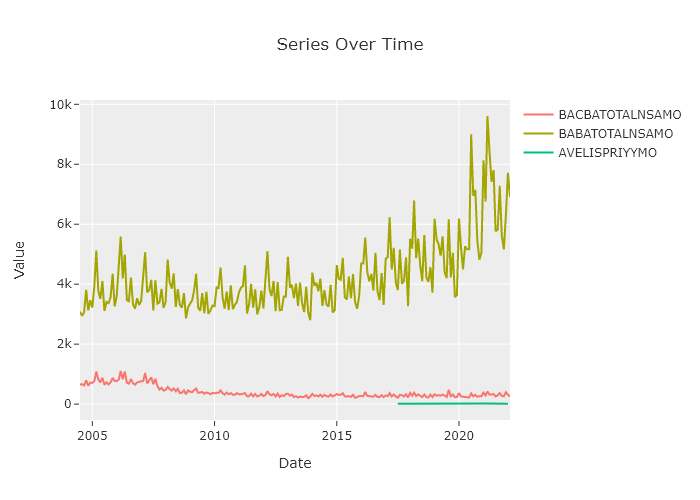

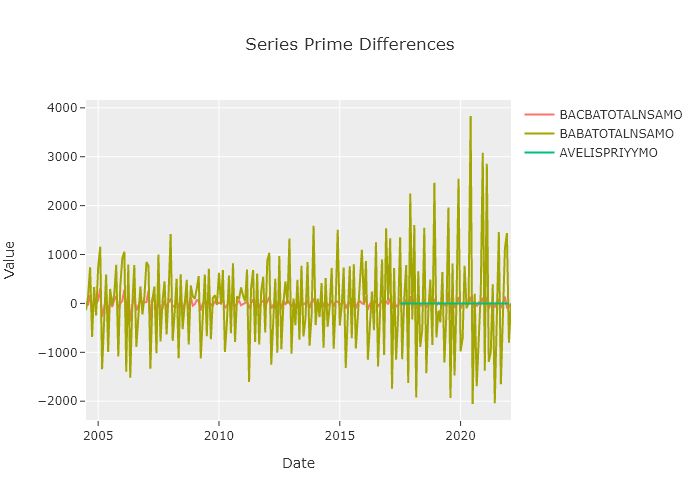

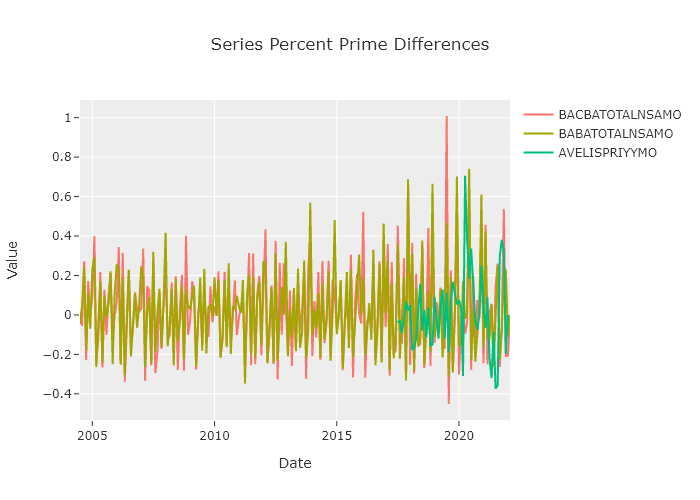

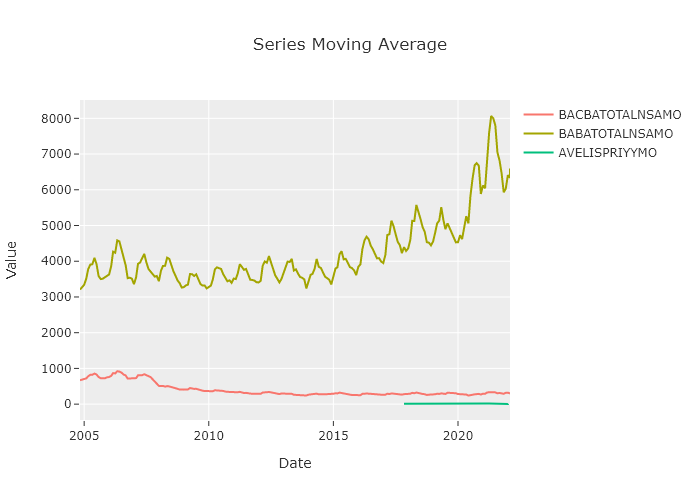

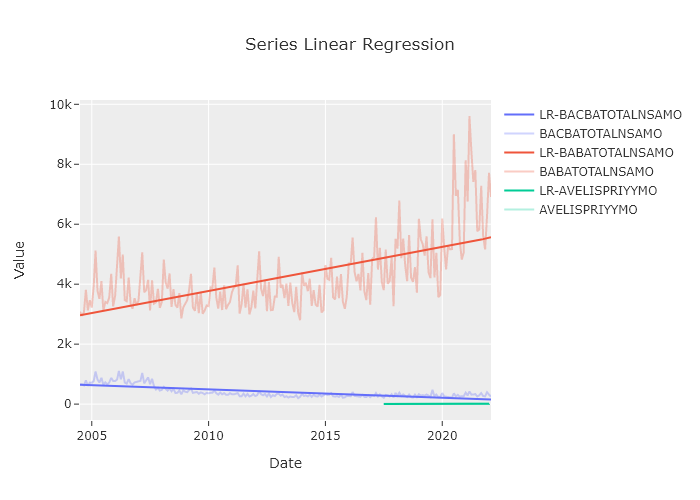

Il tutto si può ottenere tramite questo codice presente nel modulo `test.py`:

In [ ]:
    f_api = FredApiManager("e5889c59144fa74e5235e15a0d1037ff", './frappy.db')
    # root = Category(0, "root", None, None, None, None)
    root = Category(154, "Missouri", None, None, None, None)

    # get category tree
    categories = []
    t0 = time.time()
    categories += f_api.req_cat_start(root, 0)
    print(time.time()-t0)
    series = []
    obs = []

    # get SERIES - OK
    t0 = time.time()
    for i in categories:
        if i.n_series != 0:
            series.append(f_api.request_series(i, False))
    print(time.time()-t0)

    print(series)

    # get OBSERVABLES
    t0 = time.time()
    index = 0
    array = series[0]
    #sto prendendo TUTTE le osservabili da 16 serie relative a una categoria.
    for i in array:
        #obs.append([])
        if i.n_observables != 0:
            obs.append(f_api.request_observables(i, False))
        index += 1
        print(index)
        if index > 15:
            break
    f_api.dbm.close_db()
    print(time.time()-t0)

    # GRAPHS
    first_list = obs[10]
    second_list = obs[8]
    third_list = obs[7]
    data_to_plot = [first_list, second_list, third_list]
    print(data_to_plot)

    # INIZIO TEST stats.py

    print("time series")

    graphs = Graphs(data_to_plot, "ggplot2", "png")
    graphs.plot_series(True)
    graphs.print_covariance()
    graphs.plot_moving_average(5, False)
    graphs.plot_prime_differences()
    graphs.plot_prime_differences_percent()
    graphs.plot_linear_regression()
    sys.exit()